# 위도 경도 좌표정보를 이용해서 사고다발지별로 군집화, 새로운 변수 생성해보기

In [1]:
#-*- coding: euc-kr -*-



import plotly.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import mixture

from sklearn.cluster import DBSCAN
from sklearn import metrics

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100


# 데이터셋 저장 경로
ACCIDENT_PATH = "../9th_week/교통사망사고정보"
SUPPLEMENT_PATH1 = "../9th_week/보조데이터/04.무단횡단사고다발지"
SUPPLEMENT_PATH2 = "../9th_week/보조데이터/05.보행노인사고다발지"
SUPPLEMENT_PATH3 = "../9th_week/보조데이터/06.보행어린이사고다발지"
SUPPLEMENT_PATH4 = "../9th_week/보조데이터/07.스쿨존내사고다발지"
SUPPLEMENT_PATH5 = "../9th_week/보조데이터/08.자전거사고다발지"


def load_accident_data(accident_path=ACCIDENT_PATH):
    csv_path = os.path.join(accident_path, "Kor_Train_교통사망사고정보(12.1~17.6).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train = load_accident_data()

In [2]:
train.shape

(25037, 27)

###  발생지 변수생성
발생지시도와 발생지시군구를 합쳐서 발생지 변수를 생성 총 231개 발생지가 나온다

In [3]:
train['발생지'] = train['발생지시도'] + train['발생지시군구']
len(np.unique(train['발생지']))

231

In [4]:
train = train[(train.경도 > 125) & (train.경도 < 130) & (train.위도 > 34) & (train.위도 < 38.5)]

In [5]:
train['발생지'] = train['발생지시도'] + train['발생지시군구']
len(np.unique(train['발생지']))

228

In [6]:
X = train[["경도", "위도"]].values

In [7]:
db = DBSCAN(eps=0.01, min_samples=9).fit(X)     ## 221 
#db = DBSCAN(eps=0.02, min_samples=13).fit(X)   ## 154
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 221


In [8]:
unique_labels = set(labels)
len(labels[labels == 1])

648

### DBSCAN을 사용해서 군집화를 해보면
색깔이 있는 원은 각 군집의 중심을 나타내고 상대적으로 작고 검은색 점은 군집에 포함되지 않는 노이즈를 나타낸다<br>
그럼 여기서 내가 해야할 작업은 각 군집의 중심을 기준으로 발생지 231개가 어떤 군집에 포함이 되고, 포함이 된다면 확률은 얼마인지 나타내야 하는것

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



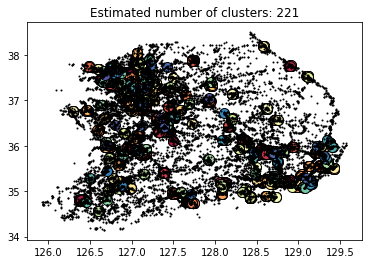

In [9]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### components의 수를 몇개로 할것인가?
발생지시도와 발생지시군구를 합쳐서 만든 변수인 발생지 변수에선 231 개의 구역이 나왔다<br>
행정구역상 기준으로한다면 위 기준으로 하는 것이 맞으나<br>
사고다발지를 계산해서 데이터 자체에 의미있는 새로운 변수를 생성하는데는 적합하지 않을수있다<br>
아래 그래프는 gmm과 같은 generative 모델의 경우 데이터에 주어지는 고유의 확률분포에 따라<br>
정보량을 측정할수있는 측정기준을 제공한다, AIC와 BIC는 각각 다음과 같다 <br>
Akaike information criterion<br>
Bayesian information criterion<br><br>

교통사망사고 데이터에 AIC, BIC 함수를 이용해서 components의 수를 찾아보면<br>
BIC는 우리가 160개 정도를 선택하는게 적절한 것을 알려준다<br>

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



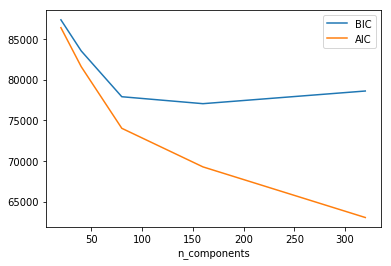

In [10]:
n_components = [20, 40, 80, 160, 320]
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

###  GaussianMixture 모델을 사용해서 군집화를 해보면
이전 모델과는 달리 components의 갯수를 직접 설정해주어야 한다
(160개로 설정한 이유는 아래 부분 참고)<br>
가우시안 모델이다보니 따로 노이즈로 표시되지 않고 같은 클러스터라면 우선 동일한 색으로 표시가된다<br>

In [11]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=160, covariance_type='full', random_state=42).fit(X)
labels = gmm.predict(X)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



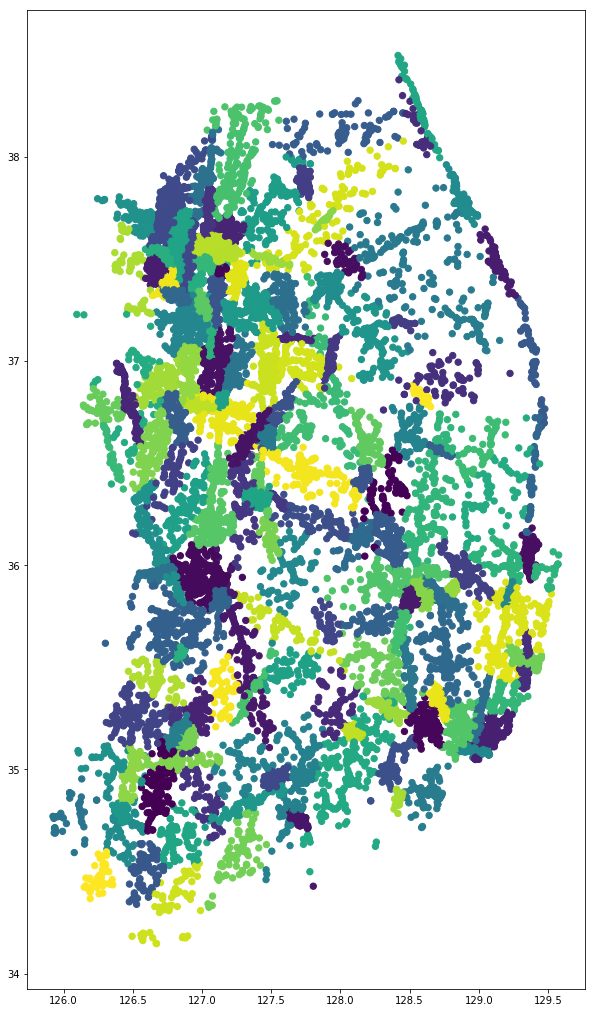

In [12]:
plt.figure(figsize=(10,18))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [13]:
probas = gmm.predict_proba(X)
probas.shape

np.amax(probas, axis=1)

array([0.87533603, 0.9890083 , 0.80929418, ..., 0.80838855, 0.99832886,
       0.78569689])

In [14]:
labels.shape

(24538,)

In [15]:
dpgmm = mixture.BayesianGaussianMixture(n_components=160, covariance_type='full').fit(X)
labels = dpgmm.predict(X)

/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:264: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



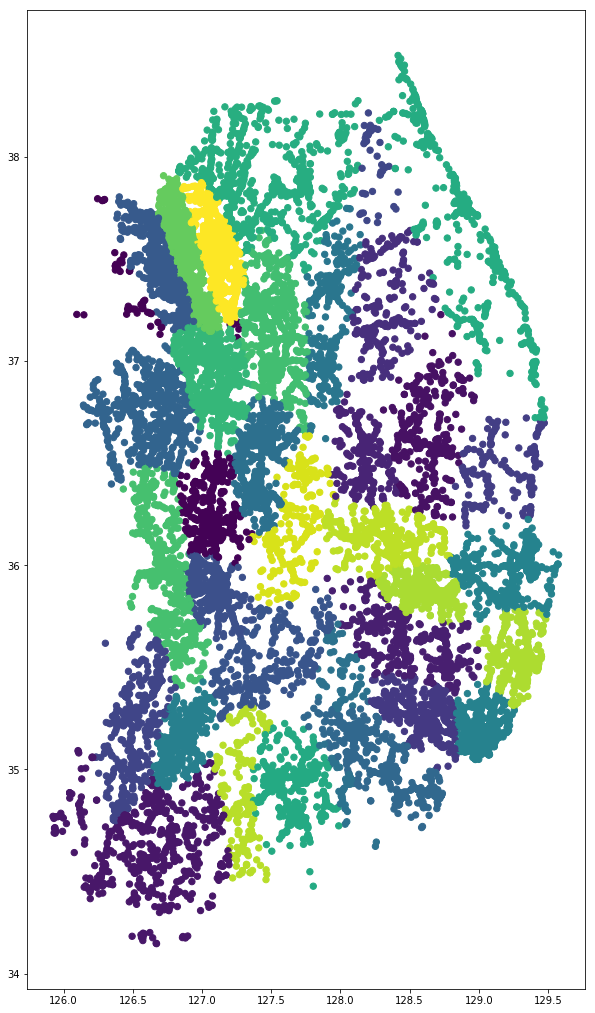

In [16]:
plt.figure(figsize=(10,18))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [17]:
dpprobas = dpgmm.predict_proba(X)
dpprobas.shape

dp_probas = np.amax(dpprobas, axis=1)

In [18]:
dp_probas.shape

(24538,)

In [19]:
labels.shape

(24538,)

In [20]:
train["클러스터번호"] = labels

train["클러스터속할확률"] = dp_probas

In [21]:
train.head(5)

,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,사고유형,법규위반_대분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,발생지,클러스터번호,클러스터속할확률
0,2017,2017063023,14,야간,금,1,1,0,0,0,경기,성남시,차대사람,횡단중,횡단중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,보행자,보행자,967633,1937456,127.134130,37.435704,경기성남시,138,0.872466
1,2017,2017063021,45,야간,금,1,4,2,1,0,전남,곡성군,차대차,추돌,추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,승용차,승용차,966456,1696405,127.131220,35.262534,전남곡성군,41,0.394028
2,2017,2017063021,50,야간,금,1,1,0,0,0,충남,서산시,차대사람,차도통행중,차도통행중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,보행자,보행자,900057,1865697,126.379922,36.784142,충남서산시,48,0.971402
3,2017,2017063019,10,야간,금,1,1,0,0,0,대구,서구,차대차,측면충돌,측면충돌,운전자법규위반,안전운전 의무 불이행,교차로,교차로부근,승용차,승용차,이륜차,이륜차,1095230,1764891,128.554945,35.875973,대구서구,121,0.970584
4,2017,2017063017,2,주간,금,1,2,1,0,0,서울,영등포구,차대차,측면충돌,측면충돌,운전자법규위반,중앙선 침범,단일로,교량위,이륜차,이륜차,화물차,화물차,947576,1946355,126.906786,37.514993,서울영등포구,107,0.882034


In [22]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

### 현재 테스트 데이터에는 위도,경도 좌표가 없고 발생지 정보만 있다
train 데이터셋에선 동일한 발생지이더라도(발생지시도+발생지시군구) 다른 군집에 속할수도 있다<br>
대표적인 군집과 각각의 확률을 어떻게 구할것인가?<br><br>

단순 평균으로 군집과 확률을 계산해도 결과에 영향을 미치지 않을까?


In [23]:
#train_cluster_mean = train.groupby(['발생지', '클러스터번호'])['클러스터속할확률'].mean()
#train_cluster_mean

train_cluster_mean = train.groupby(['발생지','클러스터번호']).mean()['클러스터속할확률'].reset_index()
train_cluster_mean

,발생지,클러스터번호,클러스터속할확률
0,강원강릉시,87,0.990874
1,강원고성군,87,0.836862
2,강원동해시,87,0.999394
3,강원삼척시,87,0.995792
4,강원속초시,87,0.889730
5,강원양구군,88,0.780749
6,강원양양군,87,0.916550
7,강원영월군,12,0.574704
8,강원영월군,24,0.879681
9,강원원주시,24,0.652535


In [24]:
train_cluster_mean[train_cluster_mean['클러스터속할확률'] == train_cluster_mean.groupby(['발생지'])['클러스터속할확률'].transform(max)]

,발생지,클러스터번호,클러스터속할확률
0,강원강릉시,87,0.990874
1,강원고성군,87,0.836862
2,강원동해시,87,0.999394
3,강원삼척시,87,0.995792
4,강원속초시,87,0.889730
5,강원양구군,88,0.780749
6,강원양양군,87,0.916550
8,강원영월군,24,0.879681
10,강원원주시,58,0.857997
14,강원인제군,88,0.619840


In [25]:
def load_supplement_jaywalk(accident_path=SUPPLEMENT_PATH1):
    csv_path = os.path.join(accident_path, "무단횡단사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')
train_jaywalk = load_supplement_jaywalk()

In [26]:
def load_supplement_oldwalk(accident_path=SUPPLEMENT_PATH2):
    csv_path = os.path.join(accident_path, "보행노인사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train_oldwalk = load_supplement_oldwalk()

In [27]:
def load_supplement_childwalk(accident_path=SUPPLEMENT_PATH3):
    csv_path = os.path.join(accident_path, "보행어린이사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train_childwalk = load_supplement_childwalk()

In [28]:
def load_supplement_schoolzone(accident_path=SUPPLEMENT_PATH4):
    csv_path = os.path.join(accident_path, "스쿨존내어린이사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train_schoolzone = load_supplement_schoolzone()

In [29]:
def load_supplement_bikezone(accident_path=SUPPLEMENT_PATH5):
    csv_path = os.path.join(accident_path, "자전거사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train_bikezone = load_supplement_bikezone()

### 다발지 데이터를 이용한 변수생성
발생건수를 법정동코드 기준으로 합산하여 시군구별 발생정도를 지수화<br>
단순발생건수만 포함하면 피해정도가 상대적으로 큰 사건은 작은사건과 동일하게 인식되어<br> 
사고피해정도 변수를 사용 사고피해정도도 지수화<br><br>

데이터별로 발생건수지수, 사고피해정도지수를 계산<br> 
다발지데이터 5개 * 2개변수 = 총 10개변수 생성<br>

### 그리고 추가적으로 보행노인사고다발지 데이터에서 시장 근처에서 사고가 자주발생하는 것에 착안
시군구 별로 일정규모 이상의 시장이 몇개 있는지를 계산해서 추가로

In [37]:
train_jaywalk["사고피해정도"] = train_jaywalk.사망자수*4 + train_jaywalk.중상자수*3 + train_jaywalk.경상자수*2 + train_jaywalk.부상신고자수*1
train_oldwalk["사고피해정도"] = train_oldwalk.사망자수*4 + train_oldwalk.중상자수*3 + train_oldwalk.경상자수*2 + train_oldwalk.부상신고자수*1
train_childwalk["사고피해정도"] = train_childwalk.사망자수*4 + train_childwalk.중상자수*3 + train_childwalk.경상자수*2 + train_childwalk.부상신고자수*1
train_schoolzone["사고피해정도"] = train_schoolzone.사망자수*4 + train_schoolzone.중상자수*3 + train_schoolzone.경상자수*2 + train_schoolzone.부상신고자수*1
train_bikezone["사고피해정도"] = train_bikezone.사망자수*4 + train_bikezone.중상자수*3 + train_bikezone.경상자수*2 + train_bikezone.부상신고자수*1

In [64]:
#train_jaywalk.sort_values(by="법정동코드", ascending=True)
#train_jaywalk.head(10)
train_jaywalk["법정동코드/10000"] = np.ceil(train_jaywalk.법정동코드/10000)
train_jaywalk_sum = train_jaywalk.groupby(['법정동코드/10000']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
train_jaywalk_sum

,사고피해정도,발생건수
법정동코드/10000,,
111102.0,537,198
111402.0,350,121
111702.0,124,43
112002.0,42,15
112152.0,131,46
112302.0,182,64
112602.0,143,52
112902.0,106,39
113052.0,365,120


In [65]:
train_oldwalk["법정동코드/10000"] = np.ceil(train_oldwalk.법정동코드/10000)
train_oldwalk_sum = train_oldwalk.groupby(['법정동코드/10000']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
train_oldwalk_sum

,사고피해정도,발생건수
법정동코드/10000,,
111102.0,332,119
111402.0,376,129
111702.0,122,45
112002.0,308,110
112152.0,152,51
112302.0,926,336
112602.0,424,144
112902.0,582,211
113052.0,557,193


In [68]:
train_childwalk["법정동코드/10000"] = np.ceil(train_childwalk.법정동코드/10000)
train_childwalk_sum = train_childwalk.groupby(['법정동코드/10000']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
train_childwalk_sum

,사고피해정도,발생건수
법정동코드/10000,,
111102.0,8,3
111402.0,24,9
111702.0,11,6
112002.0,10,4
112152.0,30,14
112302.0,44,17
112602.0,50,23
112902.0,55,21
113052.0,37,15


In [69]:
train_schoolzone["법정동코드/10000"] = np.ceil(train_schoolzone.법정동코드/10000)
train_schoolzone_sum = train_schoolzone.groupby(['법정동코드/10000']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
train_schoolzone_sum

,사고피해정도,발생건수
법정동코드/10000,,
1124.0,5,2
1133.0,5,2
1136.0,18,1
1139.0,11,5
1148.0,4,2
1160.0,8,4
2621.0,5,2
2633.0,5,2
2636.0,10,4


In [70]:
train_bikezone["법정동코드/10000"] = np.ceil(train_bikezone.법정동코드/10000)
train_bikezone_sum = train_bikezone.groupby(['법정동코드/10000']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
train_bikezone_sum

,사고피해정도,발생건수
법정동코드/10000,,
111102.0,64,31
111402.0,42,20
111702.0,138,53
112002.0,505,210
112152.0,862,351
112302.0,1221,551
112602.0,764,361
112902.0,282,125
113052.0,439,177
